In [1]:
from import_data_utils import *
from AlexNet_keras_model import model
import tensorflow as tf
# from models.student_models  import student3

sub = 2
cutims, voxels_ROIs_full = import_data_for_sub(sub, path)

net_size = 227
batch_size = 50
net_lim = (len(cutims) // batch_size) * batch_size

2023-11-12 14:33:27.236122: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-12 14:33:27.236443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-12 14:33:27.236722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-12 14:33:27.237046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-12 14:33:27.260020: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

Model: "Alex"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 57, 57, 96)        34944     
_________________________________________________________________
norm1 (Lambda)               (None, 57, 57, 96)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 28, 28, 96)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 256)       307456    
_________________________________________________________________
norm2 (Lambda)               (None, 28, 28, 256)       0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 13, 13, 256)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 13, 13, 384)       885120 

In [2]:
model.summary()
model.inputs

Model: "Alex"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 57, 57, 96)        34944     
_________________________________________________________________
norm1 (Lambda)               (None, 57, 57, 96)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 28, 28, 96)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 256)       307456    
_________________________________________________________________
norm2 (Lambda)               (None, 28, 28, 256)       0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 13, 13, 256)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 13, 13, 384)       885120 

[<KerasTensor: shape=(None, 227, 227, 3) dtype=float32 (created by layer 'input_1')>]

In [3]:
# ECoG
with open('/home/mor/ECoG/subjects_data/RDMv_GBL_dist10_100ms.pkl', 'rb') as f:
    RDMv= pkl.load(f)

with open('/home/mor/ECoG/subjects_data/all_images.pkl', 'rb') as f:
    cutims= pkl.load(f)

# RDMv, all_images
cutims = cv2.normalize(cutims, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
cutims = cutims.astype(np.uint8)

# Ecog
batch_size = 50
net_lim = (len(cutims) // batch_size) * batch_size

In [4]:
# # allocating memory and creating the Keras VGG16 net
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.set_visible_devices(physical_devices[1], 'GPU')

In [5]:
# net = keras.applications.VGG16(input_shape=(net_size, net_size, 3),
#                                 include_top=True, weights='imagenet')
# type(net)

In [6]:
# image resizing and padding
def resize_padding(x, des_size):
    """
    This function takes the image which is already in the desired size, but minimizes it to a smaller size
    and add padding to keep the original size.  
    """
    if x.shape[0] < des_size:
        raise ValueError("Desired size must be smaller than original size!")
    neutral_color = x[0,0,0]  #pixel from the image surrounding
    padding = np.ones(x.shape) * neutral_color
    start =(x.shape[0] - des_size)//2
    end = start + des_size
    resized_im = keras.layers.Resizing(des_size, des_size, interpolation='bilinear', crop_to_aspect_ratio=False,)(x).numpy()
    padding[start:end, start:end] = resized_im
    return padding

In [7]:
#zoomin 
def zoomin_img(img, zoomsize):
    """
    This function will zoom in the image by increasing it to a bigger size and then cut and use only the middle square of it 
    to enter the network.
    
    img: an image which is already the desired size!
    zoomin = the new bigger size which we will zoom into
    """
    origin_sz = img.shape[0]
    cut = (zoomsize-origin_sz)//2
    newim = keras.layers.Resizing(zommin, zommin, interpolation='bilinear', crop_to_aspect_ratio=False,)(img).numpy()
    cutnewim = newim[cut:origin_sz+cut,cut:origin_sz+cut]
    return cutnewim

### examples of pictures filtering

(224, 224, 3)


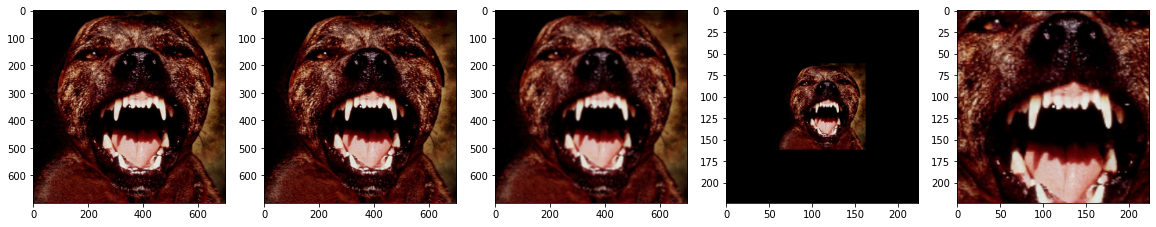

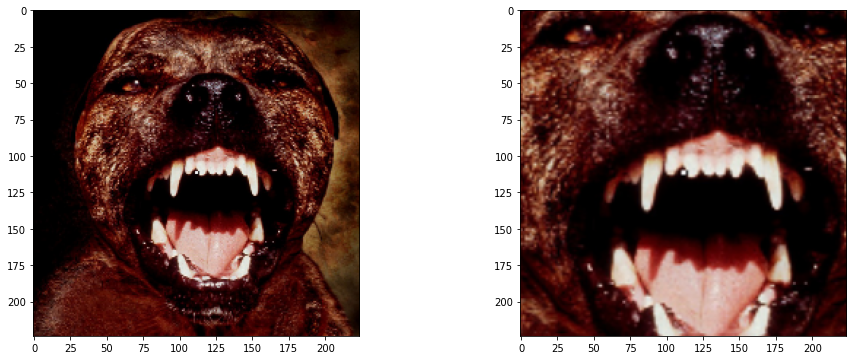

In [8]:
fig, axs = plt.subplots(1,5, figsize=(20, 6))
im1_sub1= cutims[1]
axs[0].imshow(im1_sub1, vmin=0, vmax=255)
#example of image cutting
axs[1].imshow(im1_sub1, vmin=0, vmax=255)

#example of image blurring
im1_blur = cv2.blur(im1_sub1,(7,7))
axs[2].imshow(im1_blur.astype(int))

# example of the resizing the picture and adding paddings.
img = keras.layers.Resizing(224, 224, interpolation='bilinear', crop_to_aspect_ratio=False,)(im1_sub1).numpy()
new_size = 100
img_res = resize_padding(img, new_size)
axs[3].imshow(img_res.astype(int), vmin=0, vmax=255)

#zoomin 
a = img
zommin = int(224*1.6)
origin_sz = 224
# cut = (zommin-origin_sz)//2
# a1 = keras.layers.Resizing(zommin, zommin, interpolation='bilinear', crop_to_aspect_ratio=False,)(a).numpy()
# a2 = a1[cut:zommin-cut,cut:zommin-cut]

a2 = zoomin_img(img,zommin)
axs[4].imshow(a2.astype(int), vmin=0, vmax=255)



print(a2.shape)
fig1, axs1 = plt.subplots(1,2, figsize=(16, 6))
axs1[0].imshow(img.astype(int), vmin=0, vmax=255)
axs1[1].imshow(a2.astype(int), vmin=0, vmax=255)

### ROIs

In [9]:
def corr_list_RDM(RDM_fmri1, RDM_fmri2, corr_fun=spearmanr):
    """
    This function takes and all RDMS from FMRI voxels of 2 subjects and calculate correlations.
    """
    corr_dict = {}
    for brain_area in RDM_fmri1.keys():
        mask = np.triu(np.ones(RDM_fmri1[brain_area].shape,dtype=np.bool),1)
        corr_dict[brain_area] = []
        corr, pval = corr_fun(np.nan_to_num(RDM_fmri1[brain_area][mask]),np.nan_to_num(RDM_fmri2[brain_area][mask]))
        corr_dict[brain_area].append(corr)
        print ("done correlations " + brain_area)
    return corr_dict

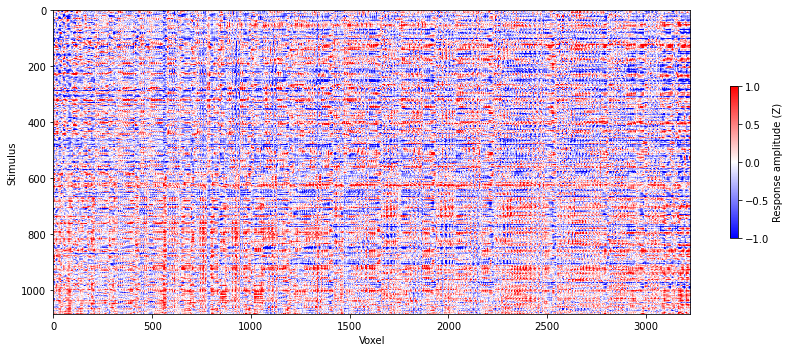

In [10]:
# Example Voxels Bold signal from voxels_vis_ROIS V1 ventral
fig, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(voxels_ROIs_full['prf-visualrois']['V1v'],
                    aspect="auto", vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
fig.tight_layout()
fig.show()

In [11]:
# calculate RDM for fmri data
RDM_fmri = {}
for area in voxels_ROIs_full.keys():
    RDM_fmri[area] = {}
    for roi in voxels_ROIs_full[area].keys():
        RDM_fmri[area][roi] = 1-np.corrcoef(voxels_ROIs_full[area][roi][:net_lim,:])
    print("Created RDM for: " + str(area))

Created RDM for: floc-bodies
Created RDM for: floc-faces
Created RDM for: floc-places
Created RDM for: floc-words
Created RDM for: prf-visualrois


/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


# Applying AlexNet

In [12]:
class pic_edit():
    """
    This class should ease applying filters and edits to the cut squered pictue before they are being proccessed by the net. 
    It aims to contain all present and future potential dynamic properties of a picture.
    """
    def __init__(self, size = 224, blur = 1):
        self.size = size
        self.blur = blur
        
    def __repr__(self):
        return f'pic({self.size, self.blur})'
    
    def __hash__(self):
        return hash((self.size, self.blur))


In [13]:
# net_data = np.load(open(path + "/bvlc_alexnet.npy", "rb"), encoding="latin1", allow_pickle=True).item()
# net_data

In [14]:
cutims[0].shape

(700, 700, 3)

In [15]:
# Bulilding Net
# net = keras.applications.VGG16(input_shape=(net_size, net_size, 3),
#                                 include_top=True, weights='imagenet')
def preprocss_net(input_size, cut_ims, pic_params):
    """
    This function exectute all needed and optional steps before implementing the network over the data
    it resizes the input, and when needed it decreses and creates padding
    """ 
    input_len = len(cut_ims)
    input_net = np.zeros((input_len, input_size, input_size,3))
    for i in range(input_len):       
        input_net[i] = keras.layers.Resizing(input_size, input_size, interpolation='bilinear', crop_to_aspect_ratio=False,)(cut_ims[i]).numpy()
        if pic_params.blur > 0:
            input_net[i] = cv2.blur(input_net[i], (pic_params.blur, pic_params.blur))
        if pic_params.size < input_size:
            input_net[i] = resize_padding(input_net[i], pic_params.size)
        elif pic_params.size > input_size:
            cut = (pic_params.size-net_size)//2
            zoomin = keras.layers.Resizing(pic_params.size, pic_params.size, interpolation='bilinear', crop_to_aspect_ratio=False,)(input_net[i]).numpy()
            cutzoom = zoomin[cut:net_size+cut,cut:net_size+cut]
            if i < 1:
                plt.imshow(cutzoom.astype(int), vmin=0, vmax=255)
                plt.show()
            input_net[i] = cutzoom
    input_net = input_net[:net_lim,...]
    input_net = input_net.astype(int)
    input_net[:,:,:, 0], input_net[:,:,:, 2] = input_net[:,:,:, 2], input_net[:,:,:, 0] # RGB -> GBR
    input_net = tf.convert_to_tensor(input_net) 
    return input_net #keras.applications.vgg16.preprocess_input(input_net)

In [16]:
# CNN applying
def preds_from_batches(layer_to_eval,data,batch_size = 256, sample_size=-1 ):
    """
    Sasha's function for CNN application. Processing each layer and saving the output
    """
    data_len = data.shape[0]
    samples_set_flag = False
    for batch in range(data_len//batch_size):
        start = batch * batch_size
        end = min((batch + 1) * batch_size, data_len)
        result = layer_to_eval(data[start:end]).numpy().reshape([end-start,-1]) # <-------
        if not samples_set_flag and sample_size > 0:
            samples = np.random.choice(result.shape[-1], sample_size)
            samples_set_flag = True
        if batch == 0:
            ll_out = np.zeros([data_len,result.shape[-1]]) if sample_size == -1 else np.zeros([data_len,sample_size])
        ll_out[start:end,:] = result if sample_size == -1 else result[:,samples]
    return ll_out

In [17]:
def corr_list_extractor(RDM_net, RDM_fmri, corr_fun=spearmanr):
    """
    This function takes all RDMs from all network layers, and all RDMS from FMRI voxels and calculate correlations.
    """
    corr_dict = {}
    for brain_area in RDM_fmri.keys():
        corr_dict[brain_area] = []
        for cnn_layer in range(len(RDM_net)):
            sz=RDM_net[cnn_layer].shape[0]
            mask = np.triu(np.ones([sz,sz],dtype=np.bool),1)
            corr, pval = corr_fun(np.nan_to_num(RDM_net[cnn_layer][mask]),RDM_fmri[brain_area][mask])
            corr_dict[brain_area].append(corr)
    print ("done correlations ")
    return corr_dict

applying network for images with params: 
 image size:227 || blur filter size: 0
0 conv1


2023-11-12 14:33:35.129031: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8300


1 norm1
2 pool1
3 conv2
4 norm2
5 pool2
6 conv3
7 conv4
8 conv5
9 pool5
10 flatten
11 fc6
12 fc7
13 fc8
14 prob
applying network for images with params: 
 image size:454 || blur filter size: 0


2023-11-12 14:33:37.313849: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


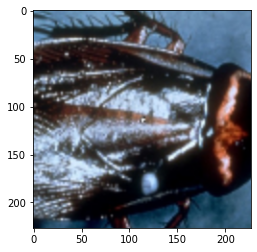

0 conv1
1 norm1
2 pool1
3 conv2
4 norm2
5 pool2
6 conv3
7 conv4
8 conv5
9 pool5
10 flatten
11 fc6
12 fc7
13 fc8
14 prob


In [18]:
# RDM of network layers
params_list = [pic_edit(net_size,0), pic_edit(int(net_size*1.2),0), pic_edit(int(net_size*1.6),0), pic_edit(int(net_size*2),0),  pic_edit(int(net_size*2.2),0), pic_edit(int(net_size*2.4),0)]
params_list = [pic_edit(net_size,0), pic_edit(net_size*2,0)]

RDM_net_sz={}
for params in params_list:
    RDM_net_sz[params] = {}
    print("applying network for images with params: \r\n image size:" + str(params.size) + " || blur filter size: "+ str(params.blur))
    input_net = preprocss_net(net_size, cutims, params)
    for ll, layer in enumerate(model.layers):
            print(ll, layer.name)
            feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output,)
            activity = preds_from_batches(feature_extractor, input_net,batch_size=batch_size, sample_size=3000)  # <-------
            RDM_net_sz[params][ll] = 1-np.corrcoef(activity)
            del feature_extractor

this is the level of the execution of the network. we can run the network as many times as we wish, changing the parameters of the pictures as desired.

# plots

In [19]:
corr_dict_ecog = {sz : corr_list_extractor(RDM_net_sz[sz], RDMv) for sz in RDM_net_sz.keys()}

done correlations 
done correlations 


In [20]:
corr_dict_ecog

{pic((227, 0)): {'V1': [-0.127135408812791,
   -0.18869375482656356,
   0.1267764985276329,
   0.2081758576187408,
   0.14355238996087832,
   0.19610278695491246,
   0.1063098714200199,
   0.08650521872696876,
   0.005623051830846531,
   0.05512063226595695,
   0.028265694532299046,
   0.12047786161773028,
   0.12261508844973551,
   0.04321582466591856,
   0.1250297313052464],
  'V2': [-0.10624222935503728,
   -0.06117604627495369,
   0.2662326464027699,
   0.22882335315855543,
   0.19323177231740984,
   0.3469318428839725,
   0.25329538014226893,
   0.19180037430959332,
   0.13541361079505213,
   0.2615398981778682,
   0.23045458966620902,
   0.19073410767243273,
   0.23034485572369237,
   0.0783639263209362,
   0.1517190628290468]},
 pic((454, 0)): {'V1': [-0.23370838710688188,
   -0.19855649274391646,
   0.024469180820778556,
   0.1030214304318791,
   0.04778714095752494,
   0.10396446996416837,
   -0.042807491675299805,
   0.02580571543462409,
   0.05202837415553497,
   0.063282200

In [21]:
corr_dict = {sz : {key : corr_list_extractor(RDM_net_sz[sz], RDM_fmri[key]) for key in RDM_fmri.keys()} for sz in RDM_net_sz.keys()}

done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 


In [22]:
def resample(mat,mat_):
    ii = np.random.randint(mat.shape[0],size=(mat.shape[0]))
    not_diag = np.eye(*mat.shape)<1e-5
    return mat[:,ii][ii,:],mat_[:,ii][ii,:],not_diag[:,ii][ii,:]

def corr_list_extractor_resampled(RDM_net,RDM_fmri,corr_fun=spearmanr):
    """
    fOR BOOTSTRAP This function takes all RDMs from all network layers, and all RDMS from FMRI voxels and calculate correlations.
    """
    corr_dict = {}
    for brain_area in RDM_fmri.keys():
        corr_dict[brain_area] = []
        for cnn_layer in range(len(RDM_net)):
            sz=RDM_net[cnn_layer].shape[0]
            mask = np.triu(np.ones([sz,sz],dtype=np.bool),1)
            RDM1, RDM2, resample_mask = resample(RDM_net[cnn_layer],RDM_fmri[brain_area])
            mask = np.logical_and(mask, resample_mask)
            corr, pval = corr_fun(np.nan_to_num(RDM1[mask]),
                                  RDM2[mask])
            corr_dict[brain_area].append(corr)
        corr_dict[brain_area] = np.array(corr_dict[brain_area])#.reshape([2,-1])
    print ("done correlations ")
    return corr_dict

n_resamples = 10
corr_dict_vis = {samp: {sz : corr_list_extractor_resampled(RDM_net_sz[sz], RDM_fmri['prf-visualrois'])  for sz in RDM_net_sz.keys()} for samp in range(n_resamples)}

done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 


In [23]:
n_resamples = 10
corr_dict_vis = {samp: {sz : corr_list_extractor_resampled(RDM_net_sz[sz], RDMv)  for sz in RDM_net_sz.keys()} for samp in range(n_resamples)}

done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 
done correlations 


# Saving the results

In [24]:
corr_dict_vis_all= {}


for area in corr_dict_vis[0][list(corr_dict_vis[0].keys())[0]].keys():
    corr_dict_vis_all[area] = []
    for ii in range(n_resamples):
#         print(corr_dict_vis[ii][list(corr_dict_vis[0].keys())[0]][amp])
        corr_dict_vis_all[area].append(corr_dict_vis[ii][list(corr_dict_vis[0].keys())[0]][area])
    corr_dict_vis_all[area] = np.stack(corr_dict_vis_all[area])
corr_dict_vis_all
# corr_dict_vis_all



{'V1': array([[-0.1039012 , -0.08060653,  0.26933622,  0.26631467,  0.07730944,
          0.25118089, -0.00617622,  0.26410327,  0.14604921,  0.08414309,
         -0.01095634,  0.13882312,  0.11832352, -0.03375712,  0.2233537 ],
        [-0.20269883, -0.24755181,  0.19521732,  0.09203919,  0.12243423,
          0.20244442,  0.11723259,  0.2718016 ,  0.02344963, -0.08551447,
         -0.09444769,  0.07462305,  0.2130133 ,  0.01344214,  0.11481405],
        [-0.14373409, -0.11441949,  0.04155296,  0.08341813,  0.14917473,
          0.10340674,  0.28098023,  0.16565822,  0.08145222,  0.10569774,
         -0.0086653 ,  0.21995218,  0.21202787,  0.03093541,  0.0445532 ],
        [-0.19008931, -0.1295457 ,  0.22465595,  0.21026346,  0.13150046,
          0.22132955,  0.05967813,  0.0207181 ,  0.0513635 ,  0.13251613,
         -0.03928016,  0.07448851,  0.11413465,  0.03862923,  0.22349345],
        [-0.05069405, -0.23708483, -0.06158674,  0.10867425,  0.13054029,
          0.34105971,  0.174

In [25]:
run_time = datetime.now().strftime("%Y%m%d%H%M")
run_time

path_for_save = "/home/mor/NDS_project/results_data/sub" + str(sub) + "/Alexnet/FF/Alexnet_results_" + run_time
path_for_save = '/home/mor/ECoG/subjects_data/results/Alexnet/FF/FF_' + run_time

# Check whether the specified path exists or not
if not os.path.exists(path_for_save):
   # Create a new directory because it does not exist
   os.makedirs(path_for_save)
   print("The new directory "+ path_for_save +" is created!")

with open(path_for_save + '/corr_dict.pkl', 'wb') as handle:
    pkl.dump(corr_dict_ecog, handle, protocol=pkl.HIGHEST_PROTOCOL)
    print("saved corr_dict!")
    
with open(path_for_save + '/RDM_net_sz.pkl', 'wb') as handle:
    pkl.dump(RDM_net_sz, handle, protocol=pkl.HIGHEST_PROTOCOL)
    print("saved RDM_net_sz!")

with open(path_for_save + '/corr_dict_vis_all.pkl', 'wb') as handle:
    pkl.dump(corr_dict_vis_all, handle, protocol=pkl.HIGHEST_PROTOCOL)
    print("saved corr_dict_vis_all!")

with open(path_for_save + '/results_explained.txt', 'a') as f:
    f.write("Subject number: " + str(sub))
    f.write(input() + '\n')
    

The new directory /home/mor/ECoG/subjects_data/results/Alexnet/FF/FF_202311121433 is created!
saved corr_dict!
saved RDM_net_sz!
saved corr_dict_vis_all!
RDMv_GBL_dist10_100ms
